<a href="https://colab.research.google.com/github/Eric-Chung-0511/Learning-Record/blob/main/Data%20Science%20Projects/Credit%20Card%20Fraud%20Detection/Credit_Card_Fraud_Detection_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.3 MB/s eta 0:00:00


In [3]:
!pip install xgboost

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat

from sklearn.utils import shuffle, compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/content/drive/Othercomputers/我的 MacBook Pro/Learning/Project/Credit Card Fraud Detection/creditcard.csv')

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


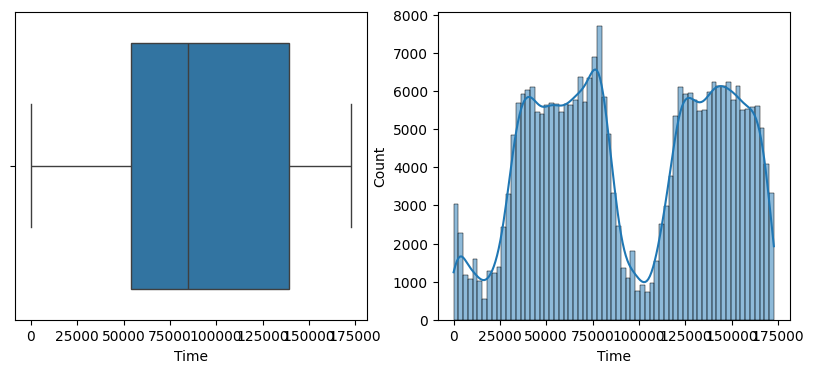

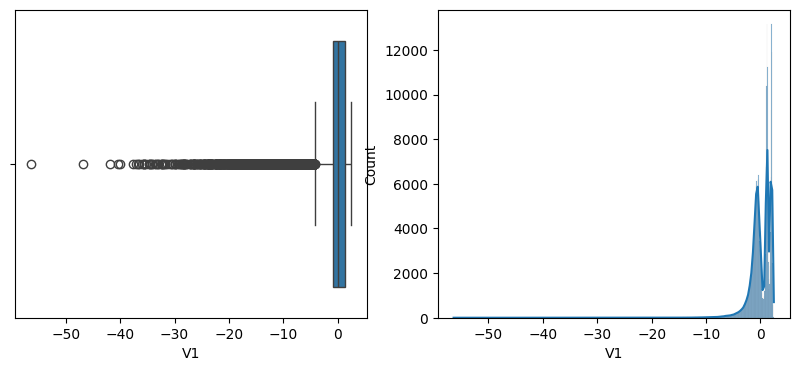

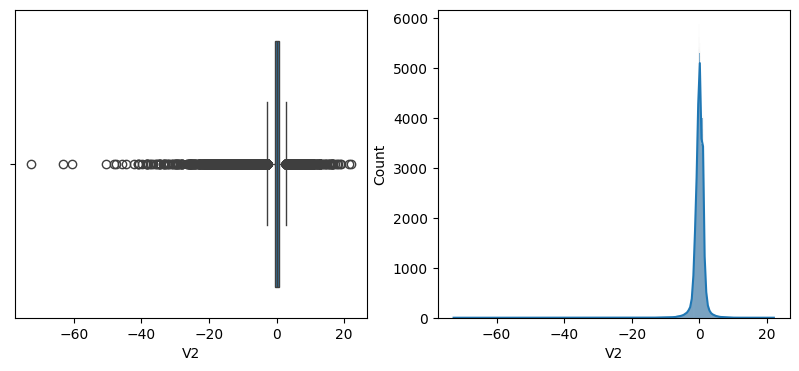

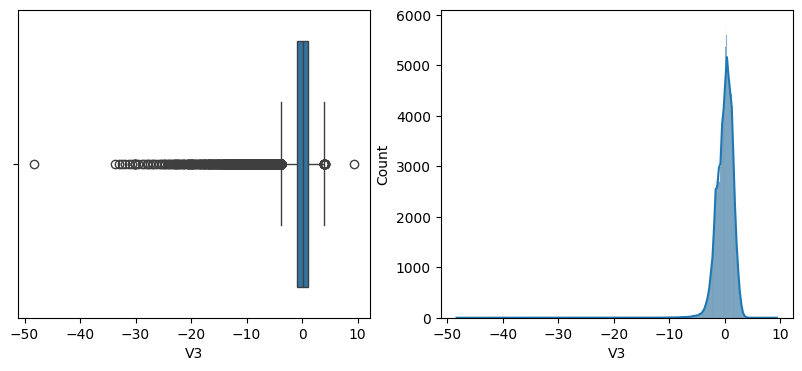

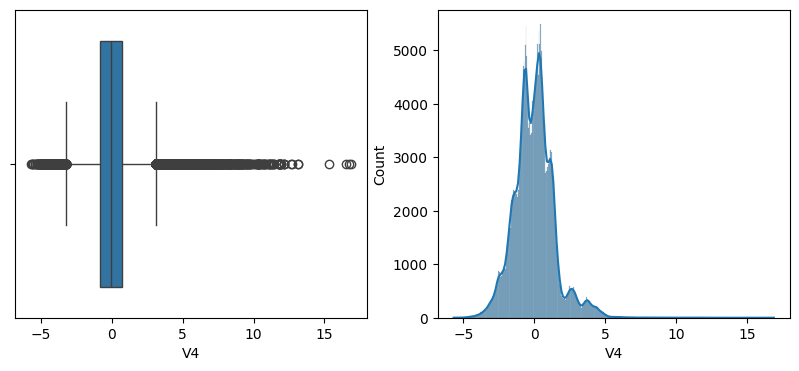

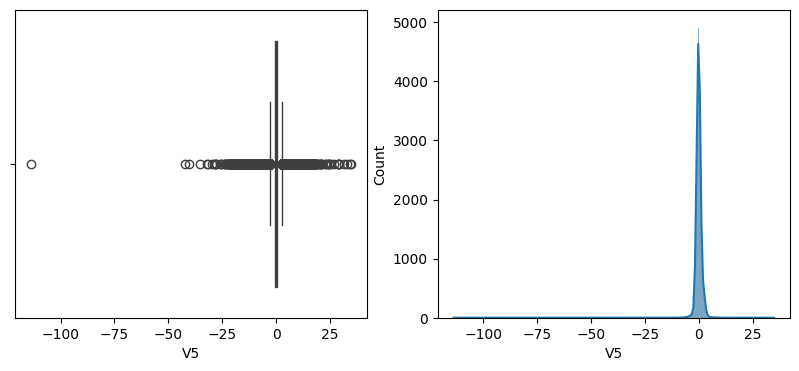

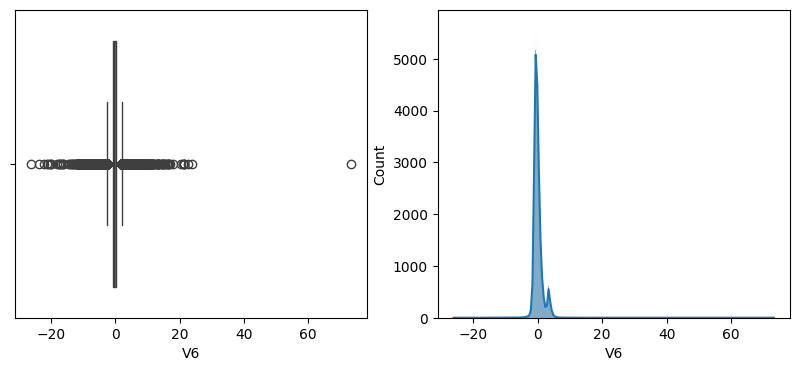

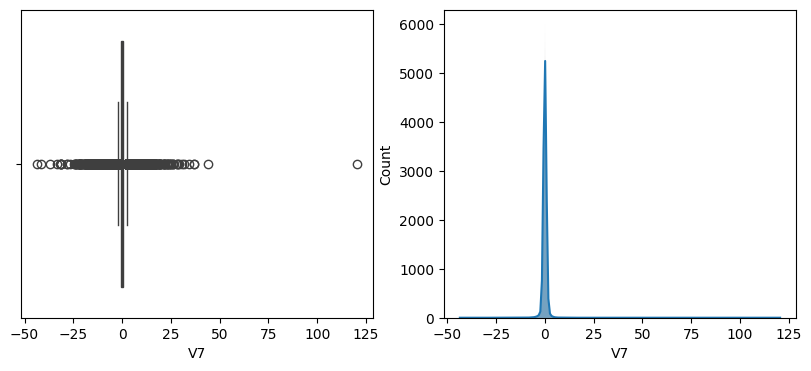

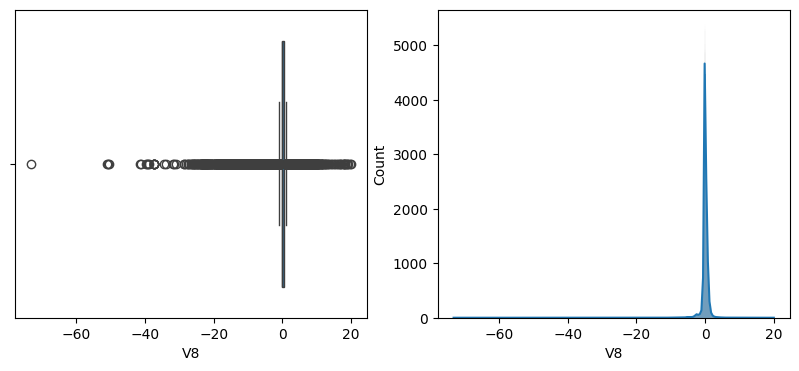

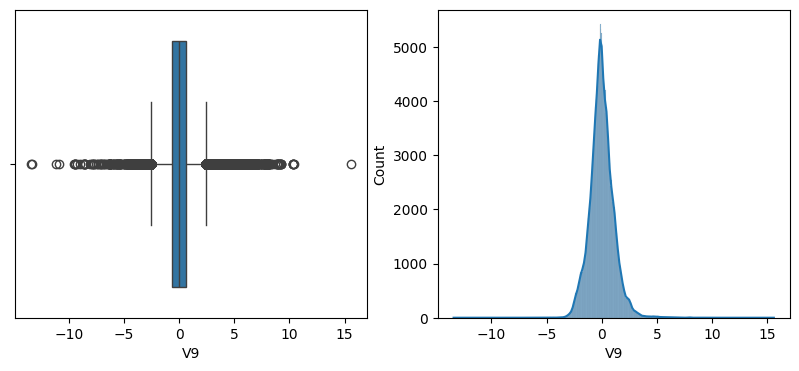

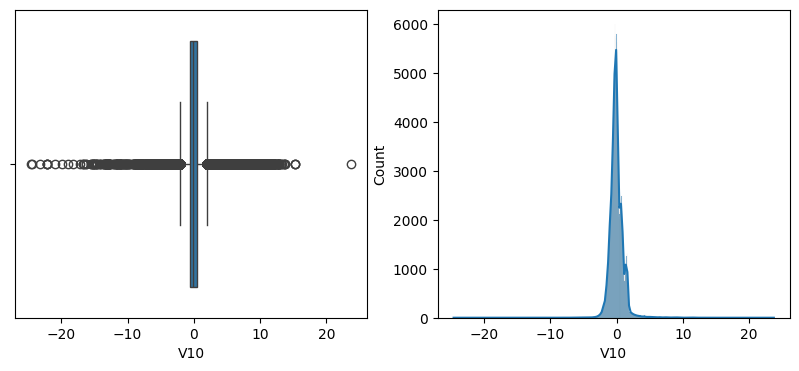

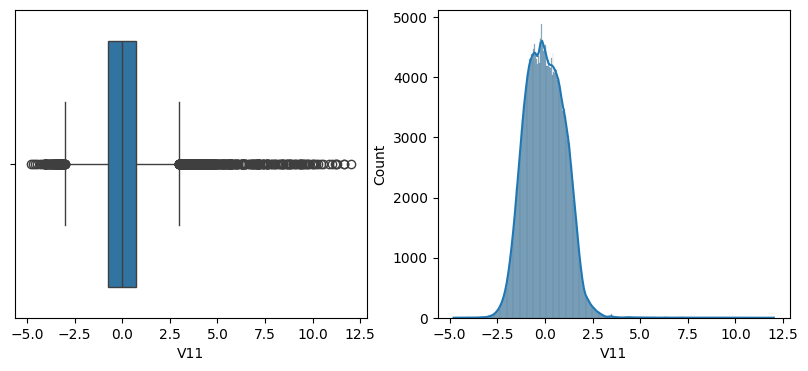

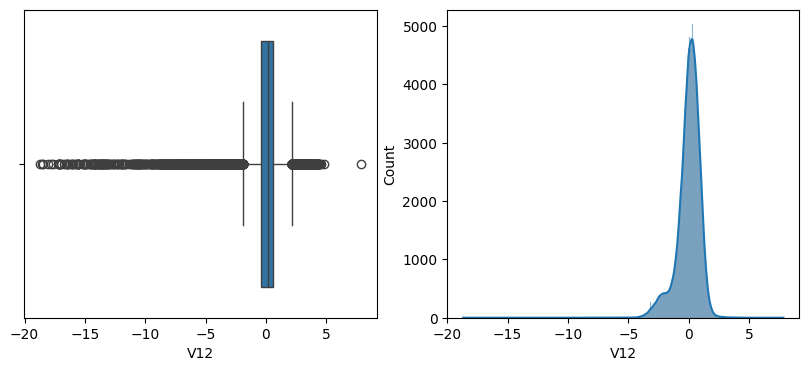

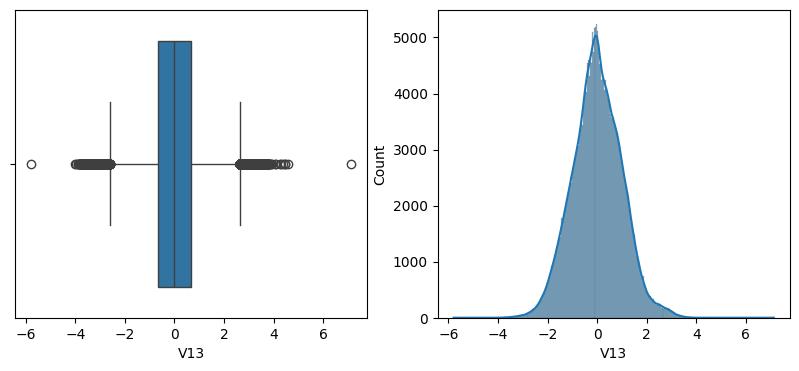

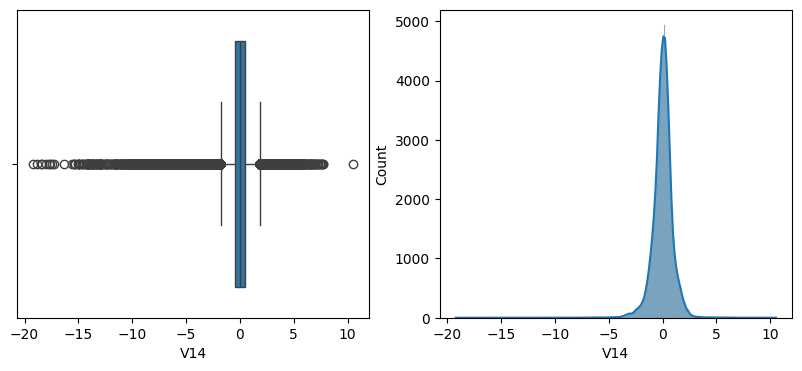

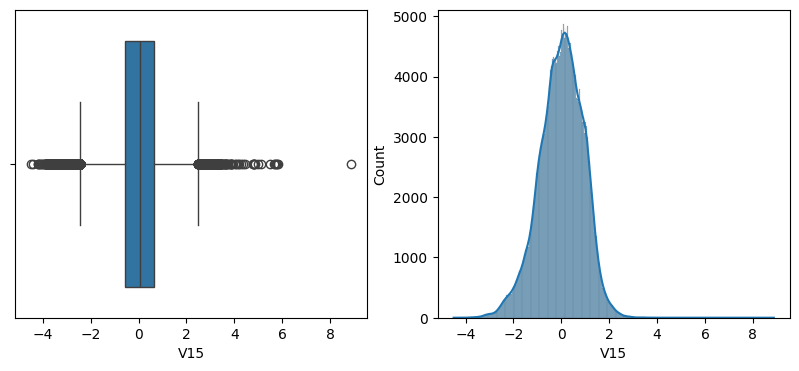

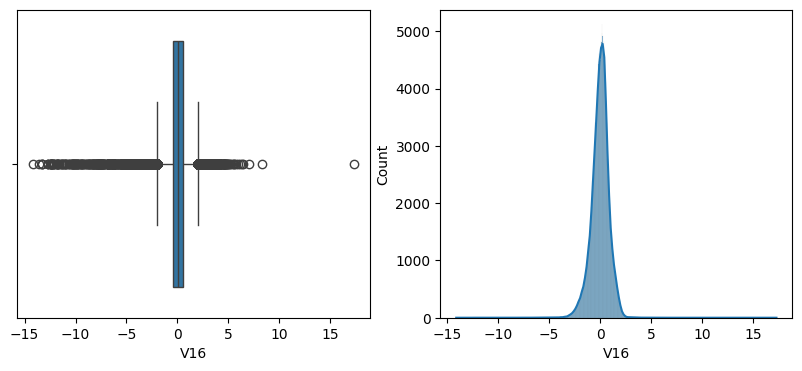

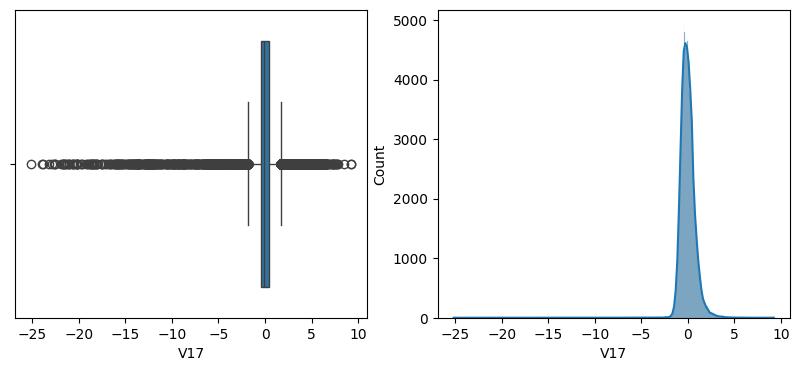

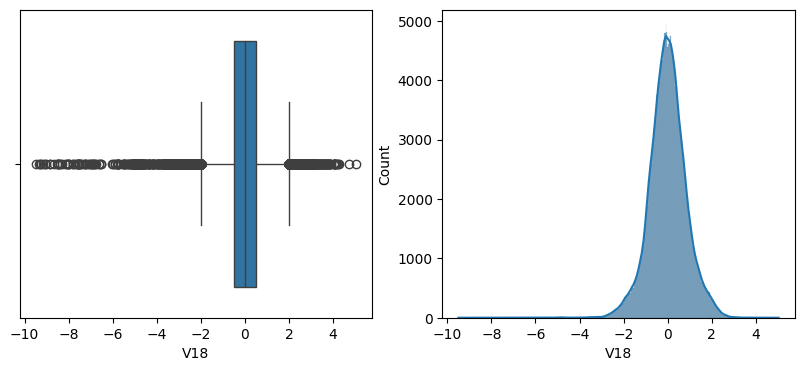

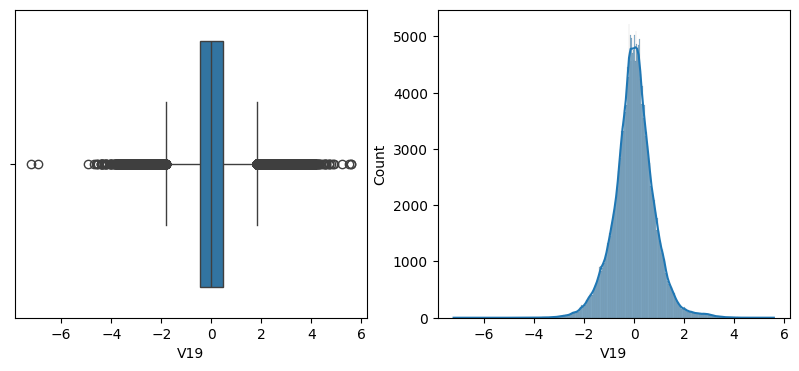

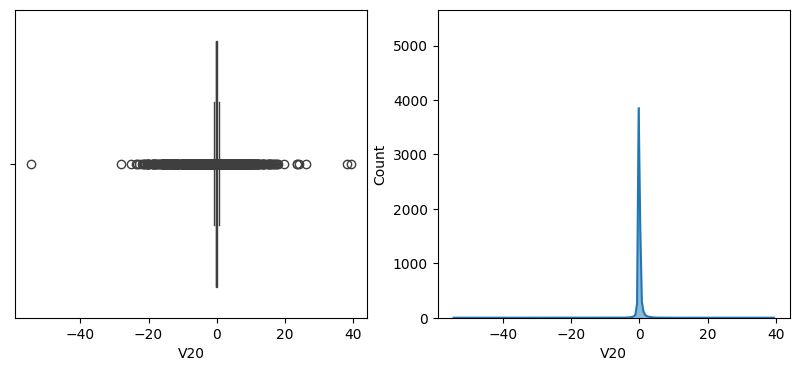

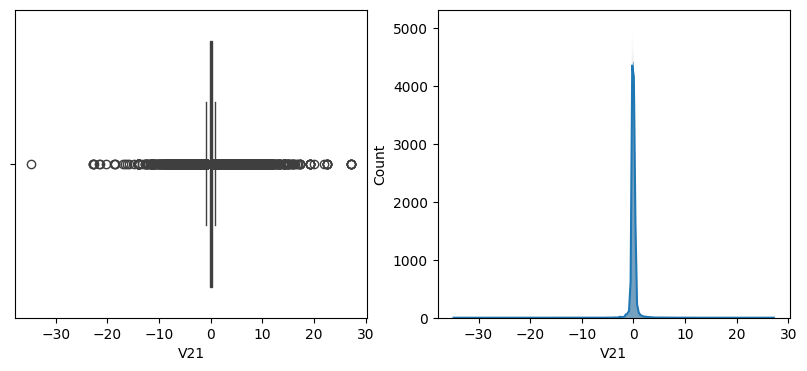

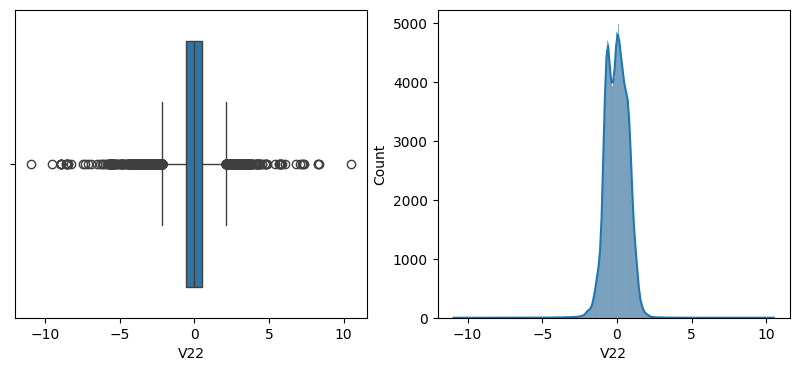

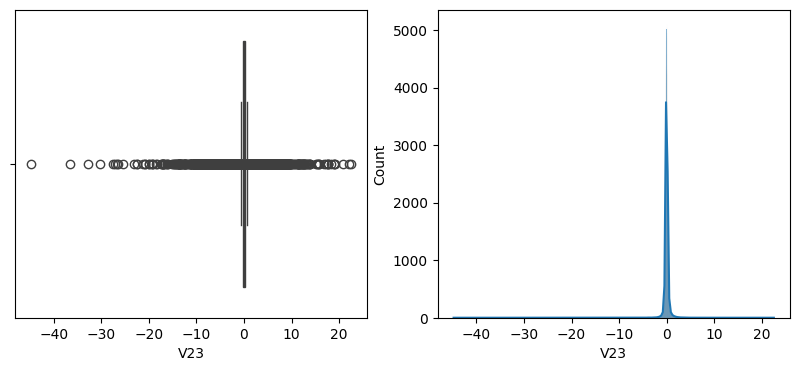

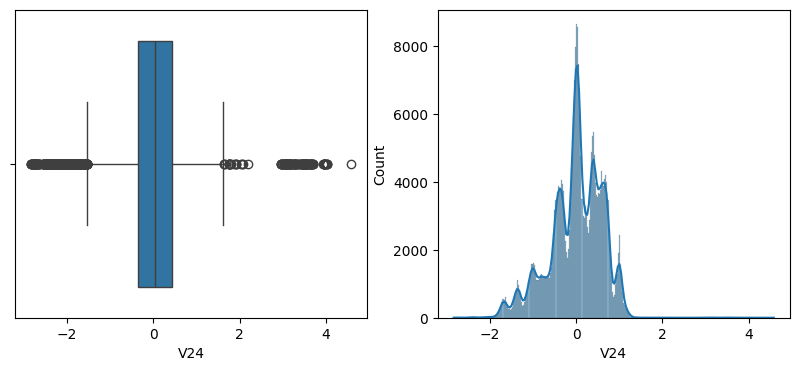

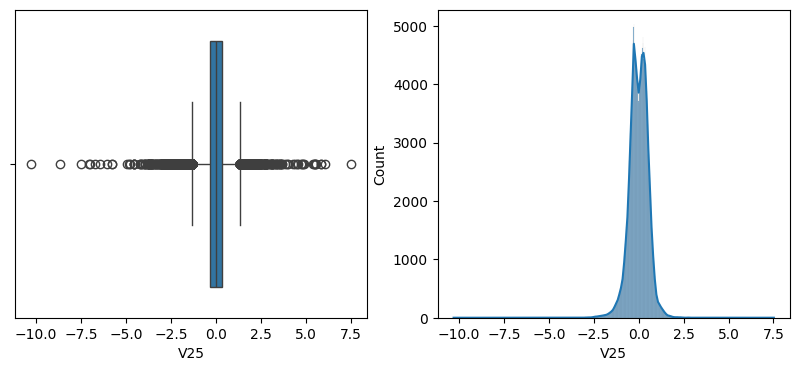

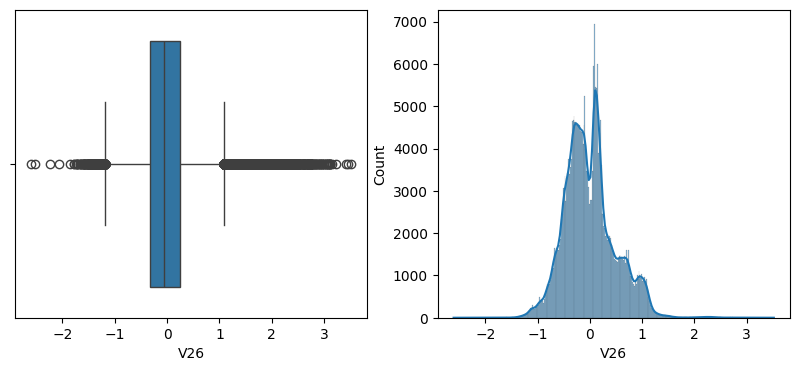

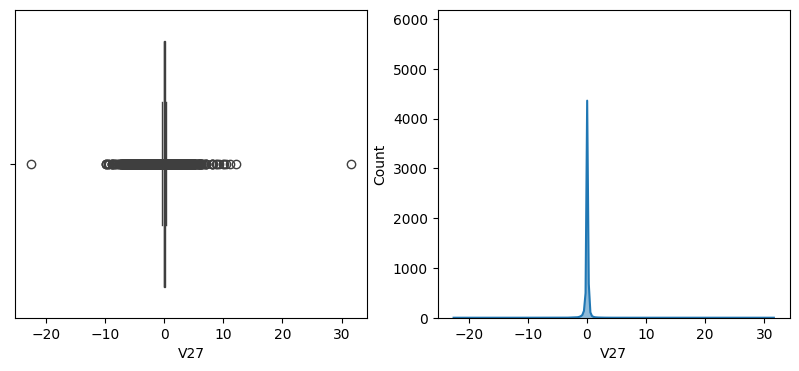

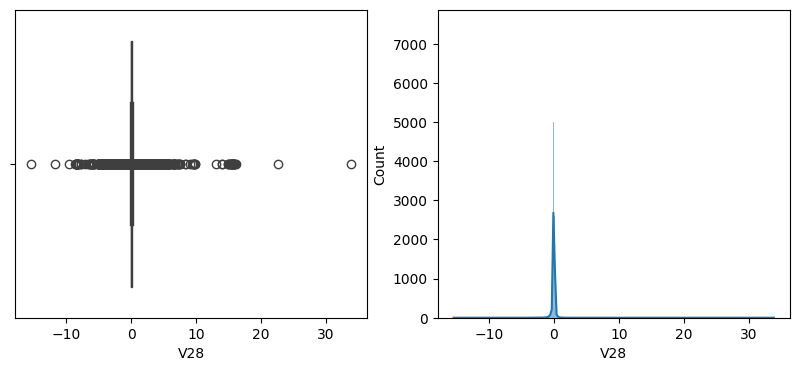

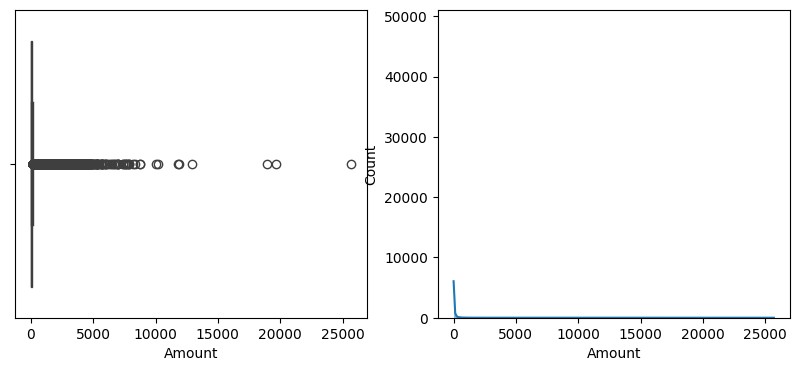

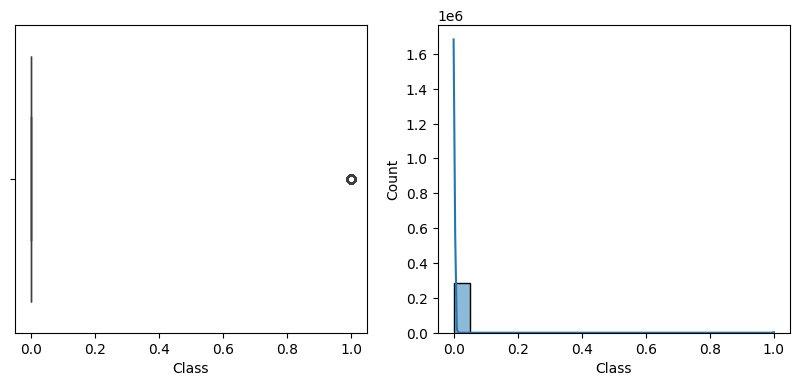

In [10]:
# Most features contain outliers
for feats in df.columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    ax0 = axes[0]
    sns.boxplot(data=df, x=feats, ax=ax0)

    ax1 = axes[1]
    sns.histplot(data=df, x=feats, kde=True, ax=ax1)

    plt.show()

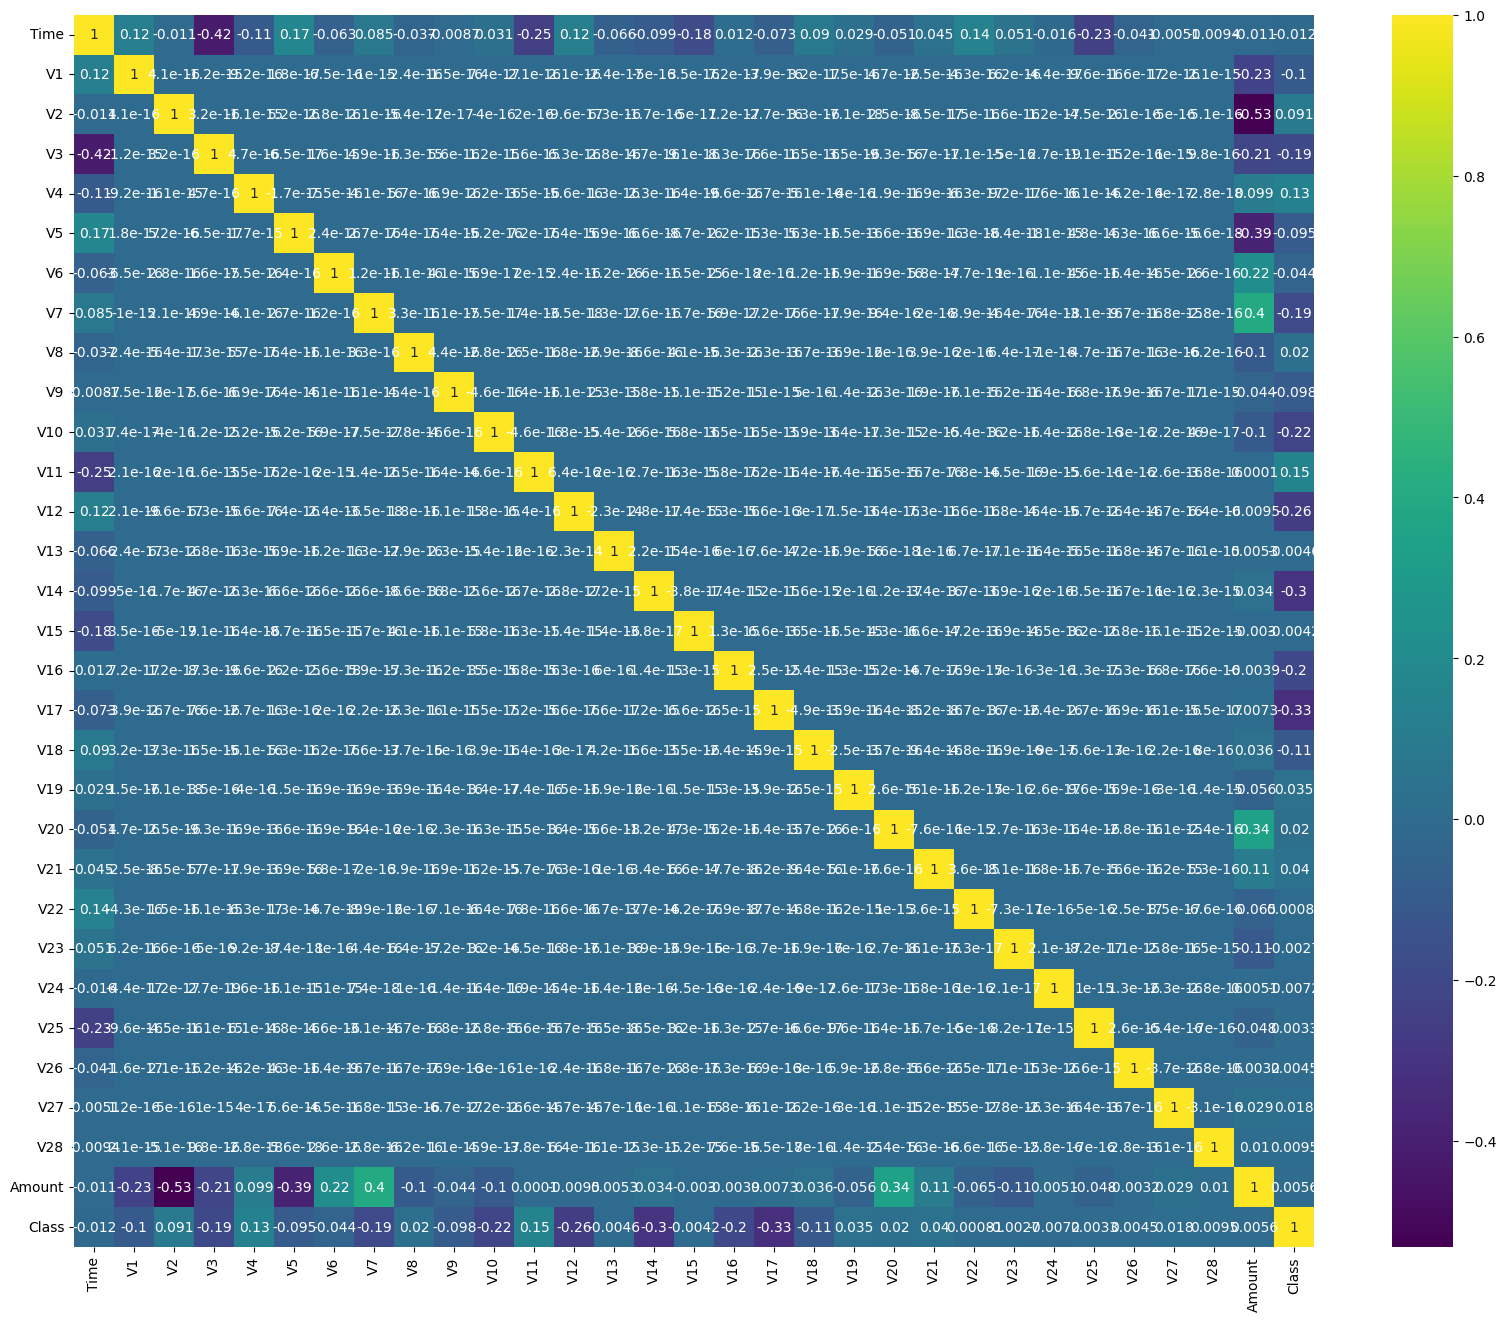

In [11]:
plt.figure(figsize=(20,16))
df_corr = df.corr()
sns.heatmap(df_corr, annot=True, cmap='viridis')
plt.show()

In [12]:
# log tranformation
df['Amount_log'] = np.log1p(df['Amount'])

In [13]:
df.drop(['Amount', 'Time'], axis=1, inplace=True)

In [14]:
# Find outliers and handle it
def handle_outliers(df, column_name, method=None):

    if method is None:
        print('No method provieded. Returning Original Data.')
        return df

    df_copy = df.copy()
    if method == 'median':

        # calculate the median value
        median = df_copy[column_name].median()

        # Use IQR Method
        Q1 = df_copy[column_name].quantile(0.25)
        Q3 = df_copy[column_name].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR

        # if not outliers return df, if it is outleirs use median replace
        df_copy[column_name] = df_copy[column_name].where(~((df_copy[column_name] < lower_bound)| (df_copy[column_name] > upper_bound)),
                                                             other=median)
        # quantile trimming
    elif method == 'quantile':

        df_copy[column_name] = np.log1p(df_copy[column_name])

        lower_quantile = df_copy[column_name].quantile(0.01)
        upper_quantile = df_copy[column_name].quantile(0.99)

        # refrain the range between lower_quantile to upper_quantile
        df_copy[column_name] = df_copy[column_name].clip(lower_quantile, upper_quantile)

    else:
        print('Invalid method provided')
        return df

    return df_copy

## Handle Outliers using Median

In [15]:
df_median = handle_outliers(df.copy(), 'Amount_log', method='median')

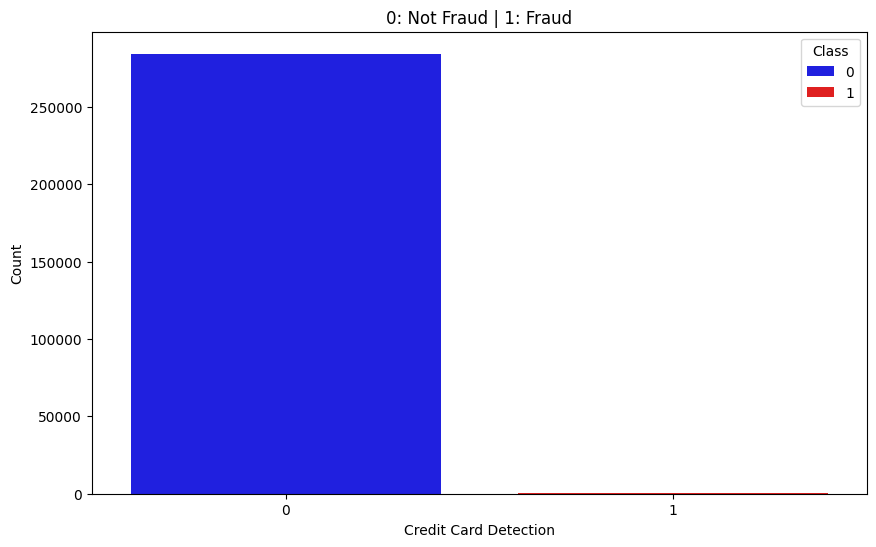

Not Fraud: 99.83%
Fraud: 0.17%


In [16]:
# Not Fruad
df_0 = df_median[df_median['Class'] == 0]

# Fraud
df_1 = df_median[df_median['Class'] == 1]

merged_df = pd.concat([df_0, df_1])

plt.figure(figsize=(10,6))
sns.countplot(data=merged_df, x='Class', hue='Class', palette=['blue', 'red'])
plt.title('0: Not Fraud | 1: Fraud')
plt.xlabel('Credit Card Detection')
plt.ylabel('Count')
plt.legend(title='Class', loc='upper right')
plt.show()

print(f'Not Fraud: {round(len(df_0) / len(df) *100, 2):.2f}%')
print(f'Fraud: {round(len(df_1) / len(df) *100, 2):.2f}%')

In [17]:
X = df_median.drop('Class', axis=1)
y = df_median['Class']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [19]:
# Use ADASYN to handle imbalanced data
adasyn = ADASYN(random_state=42)

X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

In [20]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_adasyn)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [21]:
X_train.shape

(341128, 29)

## XGBoost using Median

In [22]:
# search_spaces = {
#     'learning_rate': Real(0.01, 0.3, 'log-uniform'),
#     'max_depth': Integer(3, 10),
#     'min_child_weight': Integer(1, 10),
#     'subsample': Real(0.5, 1.0, 'uniform'),
#     'colsample_bytree': Real(0.5, 1.0, 'uniform'),
#     'n_estimators': Integer(100, 1000)
# }

# xgb_model_median = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# bayes_search = BayesSearchCV(xgb_model_median, search_spaces, n_iter=50, n_jobs=-1, random_state=42, scoring='accuracy')

# bayes_search.fit(X_train, y_train_adasyn)

# print(f'Best Parameters: {bayes_search.best_params_}')
# print(f'Best Score: {bayes_search.best_score_}')

# xgb_best_median_model = bayes_search.best_estimator_

# Best Parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.29999999999999993), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 772), ('subsample', 1.0)])
# Best Score: 0.9826721936170216

In [27]:
# Validation Set Prediction
xgb_best_median_model = XGBClassifier(
                        learning_rate=0.3,
                        max_depth=3,
                        min_child_weight=10,
                        subsample=1,
                        colsample_bytree=1,
                        n_estimators=772,
                        use_label_encoder=False,
                        eval_metric='logloss' )


xgb_best_median_model.fit(X_train, y_train_adasyn)


# For binary classification, predict the probability of each sample in the validation set belonging to
# the positive class.
prediction = xgb_best_median_model.predict(X_val)

# 使用 classification_report 來生成分類報告
print("Validation Set Classification Report:")
report_val = classification_report(y_val, prediction)
print(report_val)

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56884
           1       0.66      0.83      0.73        78

    accuracy                           1.00     56962
   macro avg       0.83      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [28]:
# Final Test Set Prediction
xgb_best_median_model = XGBClassifier(
                        learning_rate=0.3,
                        max_depth=3,
                        min_child_weight=10,
                        subsample=1,
                        colsample_bytree=1,
                        n_estimators=772,
                        use_label_encoder=False,
                        eval_metric='logloss'
)


xgb_best_median_model.fit(X_train, y_train_adasyn)


# For binary classification, predict the probability of each sample in the validation set belonging to
# the positive class.
prediction = xgb_best_median_model.predict(X_test)

# 使用 classification_report 來生成分類報告
print("Test Set Classification Report:")
report_test = classification_report(y_test, prediction)
print(report_test)

Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.86      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962



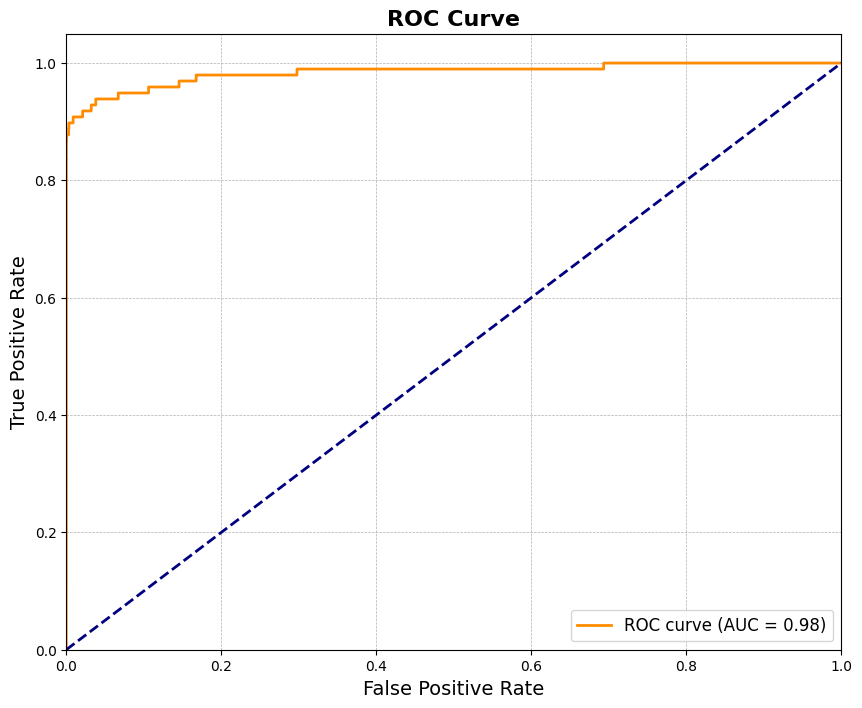

AUC: 0.98


In [53]:
def plot_roc_curve(model, X_test, y_test):
    """
    Plot ROC curve for a given model and test data.

    Parameters:
    model (object): Trained classifier with a predict_proba method.
    X_test (array-like): Test features.
    y_test (array-like): True labels for the test set.

    Returns:
    None
    """
    # Get the predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Compute the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)

    # Plot the diagonal line representing random chance
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Set axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=16, fontweight='bold')

    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.legend(loc="lower right", fontsize=12)

    plt.show()

    # Print the AUC value
    print(f'AUC: {roc_auc:.2f}')

# Call the function to plot ROC curve
plot_roc_curve(xgb_best_median_model, X_test, y_test)


## Handle Outliers using Quantile

In [31]:
df_quantile = handle_outliers(df.copy(), 'Amount_log', method='quantile')

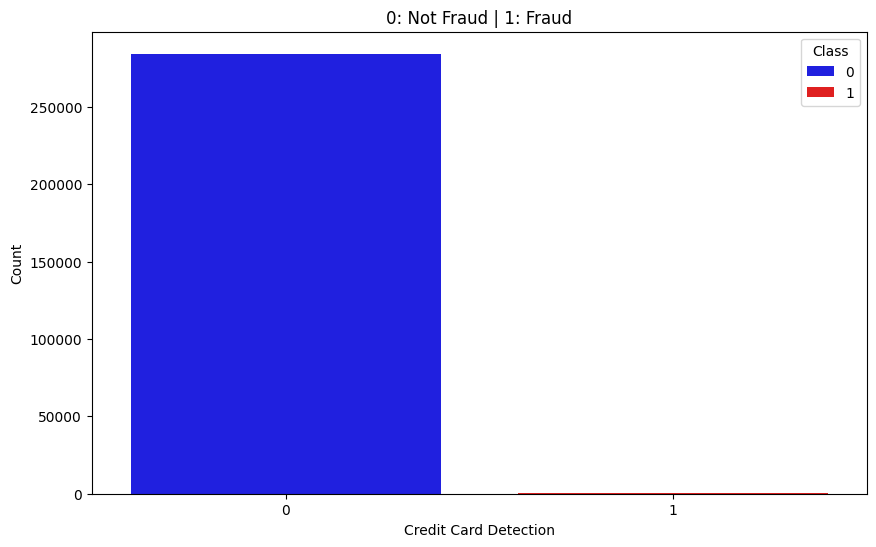

Not Fraud: 99.83%
Fraud: 0.17%


In [34]:
# Not Fruad
df_0 = df_quantile[df_quantile['Class'] == 0]

# Fraud
df_1 = df_quantile[df_quantile['Class'] == 1]

merged_df = pd.concat([df_0, df_1])

plt.figure(figsize=(10,6))
sns.countplot(data=merged_df, x='Class', hue='Class', palette=['blue', 'red'])
plt.title('0: Not Fraud | 1: Fraud')
plt.xlabel('Credit Card Detection')
plt.ylabel('Count')
plt.legend(title='Class', loc='upper right')
plt.show()

print(f'Not Fraud: {round(len(df_0) / len(df) *100, 2):.2f}%')
print(f'Fraud: {round(len(df_1) / len(df) *100, 2):.2f}%')

In [35]:
X = df_quantile.drop('Class', axis=1)
y = df_quantile['Class']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Use ADASYN to handle imbalanced data
adasyn = ADASYN(random_state=42)

X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

In [37]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_adasyn)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [38]:
X_train.shape

(341091, 29)

## ANN using Quantile

In [39]:
# search_spaces = {
#     'learning_rate': Real(0.01, 0.3, 'log-uniform'),
#     'max_depth': Integer(3, 10),
#     'min_child_weight': Integer(1, 10),
#     'subsample': Real(0.5, 1.0, 'uniform'),
#     'colsample_bytree': Real(0.5, 1.0, 'uniform'),
#     'n_estimators': Integer(100, 1000)
# }

# xgb_model_quantile = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# bayes_search = BayesSearchCV(xgb_model_quantile, search_spaces, n_iter=50, n_jobs=-1, random_state=42, scoring='accuracy')

# bayes_search.fit(X_train, y_train_adasyn)

# print(f'Best Parameters: {bayes_search.best_params_}')
# print(f'Best Score: {bayes_search.best_score_}')

# xgb_best_quantile_model = bayes_search.best_estimator_

# Best Parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.16568093125973224), ('max_depth', 3), ('min_child_weight', 5), ('n_estimators', 1000), ('subsample', 1.0)])
# Best Score: 0.9853734127098711

Best Parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.16568093125973224), ('max_depth', 3), ('min_child_weight', 5), ('n_estimators', 1000), ('subsample', 1.0)])
Best Score: 0.9853734127098711


In [40]:
# Validation Set Prediction
xgb_best_quantile_model = XGBClassifier(
                        learning_rate=0.16,
                        max_depth=3,
                        min_child_weight=5,
                        subsample=1,
                        colsample_bytree=1,
                        n_estimators=1000,
                        use_label_encoder=False,
                        eval_metric='logloss'
)


xgb_best_quantile_model.fit(X_train, y_train_adasyn)


# For binary classification, predict the probability of each sample in the validation set belonging to
# the positive class.
prediction = xgb_best_quantile_model.predict(X_val)

# 使用 classification_report 來生成分類報告
print("Validation Set Classification Report:")
report_val = classification_report(y_val, prediction)
print(report_val)

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56884
           1       0.68      0.86      0.76        78

    accuracy                           1.00     56962
   macro avg       0.84      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [46]:
# Final Test Set Prediction
xgb_best_quantile_model = XGBClassifier(
                        learning_rate=0.16,
                        max_depth=3,
                        min_child_weight=5,
                        subsample=1,
                        colsample_bytree=1,
                        n_estimators=1000,
                        use_label_encoder=False,
                        eval_metric='logloss'
)


xgb_best_quantile_model.fit(X_train, y_train_adasyn)


# For binary classification, predict the probability of each sample in the validation set belonging to
# the positive class.
prediction = xgb_best_quantile_model.predict(X_test)

# 使用 classification_report 來生成分類報告
print("Test Set Classification Report:")
report_test = classification_report(y_test, prediction)
print(report_test)

Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.87      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962



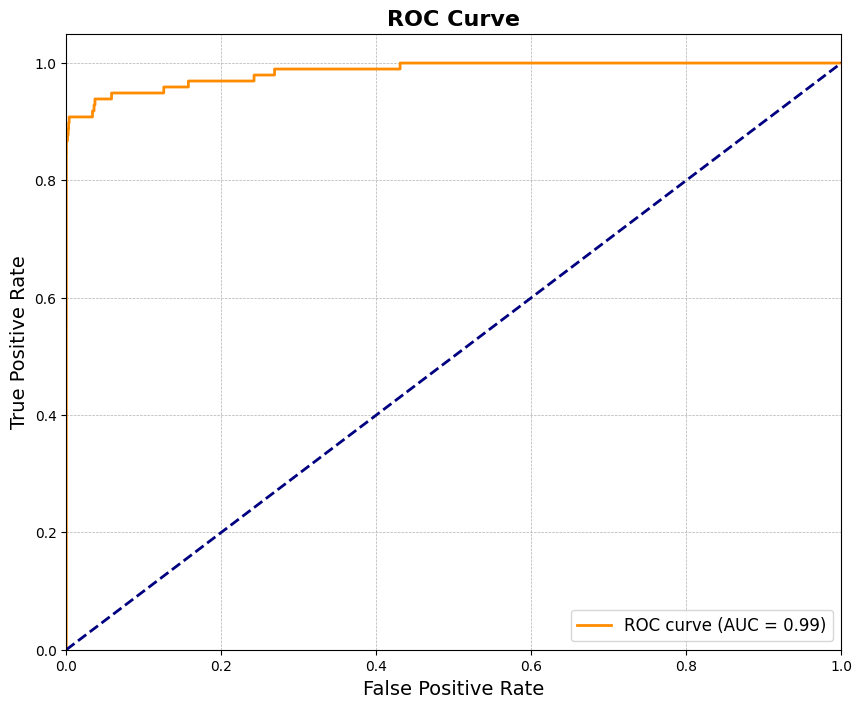

AUC: 0.99


In [54]:
def plot_roc_curve(model, X_test, y_test):
    """
    Plot ROC curve for a given model and test data.

    Parameters:
    model (object): Trained classifier with a predict_proba method.
    X_test (array-like): Test features.
    y_test (array-like): True labels for the test set.

    Returns:
    None
    """
    # Get the predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Compute the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)

    # Plot the diagonal line representing random chance
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Set axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=16, fontweight='bold')

    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.legend(loc="lower right", fontsize=12)

    plt.show()

    # Print the AUC value
    print(f'AUC: {roc_auc:.2f}')

# Call the function to plot ROC curve
plot_roc_curve(xgb_best_quantile_model, X_test, y_test)


### Model Explanation

- **Precision**  
   Precision represents the proportion of samples predicted as positive by the model that are actually positive. In this case, the precision is `0.80`, indicating that when the model predicts a sample as class 1, there is a `80% `probability of being correct.
   
- **Recall**  
  Recall represents the proportion of all positive samples that are correctly identified by the model. The recall of this model is `0.87`, indicating that the model can identify `87%` of actual class` 1 `samples.

- **F1-score**  
  The F1-score is the harmonic mean of precision and recall, used to evaluate the overall performance of the model in imbalanced data. The F1-score in this case is `0.83`, showing a good balance between the two.

- **AUC (Area Under the ROC Curve)**  
  The AUC measures the model's ability to distinguish between positive and negative classes. The AUC score ranges from 0 to 1, with a value closer to 1 indicating better discriminative performance. Specifically, an AUC value of `0.99` suggests that the model has excellent capability in distinguishing between different classes.